## Synthetic Financial Datasets For Fraud Detection
### Synthetic datasets generated by the PaySim mobile money simulator

#### The iPython notebook is created by Satsawat N.

The dataset is available via Kaggle Datasets [page](https://www.kaggle.com/ntnu-testimon/paysim1).

### Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

### Acknowledgements

This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox

import warnings
warnings.filterwarnings("ignore")

In the next coming section, I will quickly define some utilities and do some basic checking on the data.

In [3]:
# Utilities-related functions
def now():
    tmp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return tmp

def env_setup(work_dir):
    cur_dir = os.getcwd()
    if cur_dir == work_dir:
        print("{}: {} is already assigned as working directory".format(now(), work_dir))
    else:
        os.chdir(work_dir)
        print("{}: Working directory is now at {}.".format(now(), work_dir))

def my_file_read(file):
    df = pd.read_csv(file)
    print("{}: {} has {} observations and {} columns".format(now(), file, df.shape[0], df.shape[1]))
    print("{}: Column name checking::: {}".format(now(), df.columns.tolist()))
    return df

# Self-defined function to read dataframe and find the missing data on the columns and # of missing
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
                                   axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))

    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))
        

env_setup("C:/Users/ADK/Documents/2. Project/013_SyntheticFinancialData/")

2017-04-07 01:11:07: Working directory is now at C:/Users/ADK/Documents/2. Project/013_SyntheticFinancialData/.


In [4]:
raw_data = my_file_read("PS_20174392719_1491204439457_log.csv")

2017-04-07 01:11:40: PS_20174392719_1491204439457_log.csv has 6362620 observations and 11 columns
2017-04-07 01:11:40: Column name checking::: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


Check if the dataset has any null value in it.

In [5]:
print(checking_na(raw_data))

Empty DataFrame
Columns: [df_bool, df_amt, missing_ratio_percent]
Index: []


Let's touch and explore the dataset before we try to understand them in more details!!!

In [6]:
print(raw_data.head(5))
print(raw_data.describe())
print(raw_data.info())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6

### 1. EDA (exploratory data analysis )

In this section, we will do EDA to understand the data more. From the simulation, there are 5 transaction types as per illustrated below.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


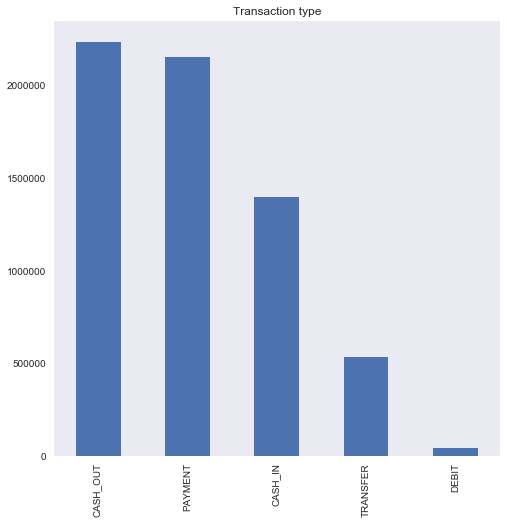

In [7]:
print(raw_data.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
raw_data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

There are 2 flags which stand out to me and it's interesting to look onto: **isFraud** and **isFlaggedFraud** column.
From the hypothesis, *isFraud* is the indicator which indicates the actual fraud transactions whereas *isFlaggedFraud* is what the system prevents the transaction due to some thresholds being triggered. 

Let's quickly what kinds of transaction are being flagged and are fraud...

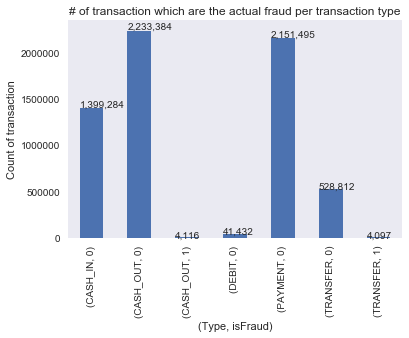

In [8]:
ax = raw_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

From this plot, we can see that fraud transaction only happened for Transfer and Cash out transaction types. We will focus on these 2 types of transaction when we move to modeling section.

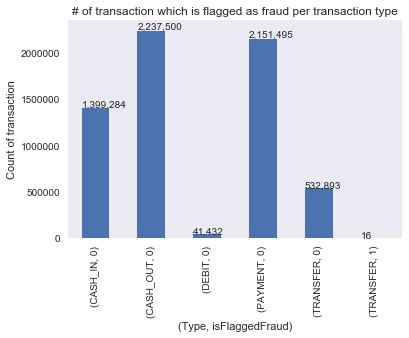

In [9]:
ax = raw_data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))


So it looks the simulation can flag only 16 transfer transactions as fraud. Let's look at those records and compare with the records which the system cannot catch'em.

The plot below will also focus only on *transfer* transaction type.

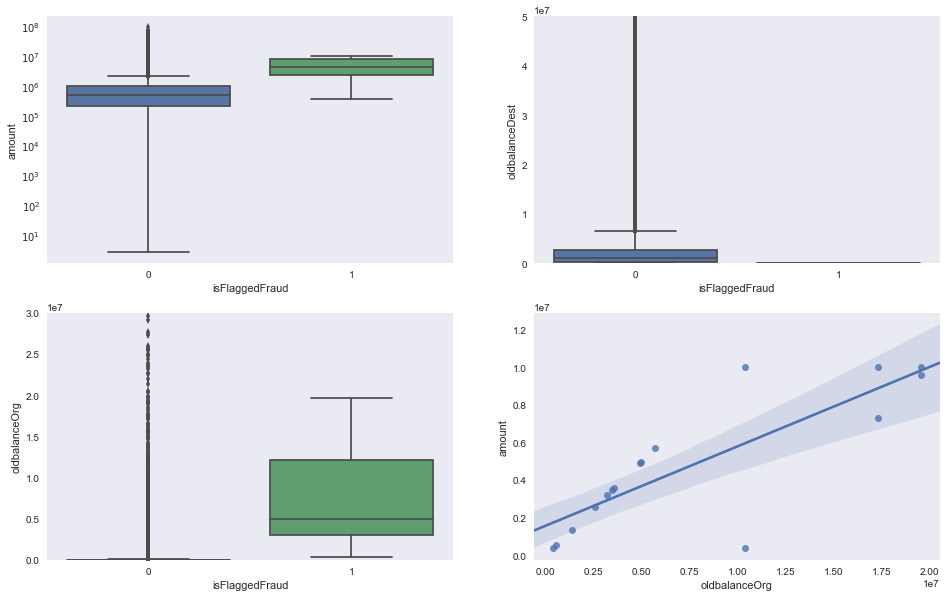

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
tmp = raw_data.loc[(raw_data.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()


It looks like **isFlaggedFraud** variable is relied on oldbalanceDest, which is 0 and some threshold on the amount variable.

## 2. Modeling

In this section, we will focus only Transfer and Cash out transaction types, as they have been identified as fraud.

In [40]:
# Keep only interested transaction type ('TRANSFER', 'CASH_OUT')

tmp = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
print(tmp.head(3))

       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   

   newbalanceDest  isFraud  
0            0.00        1  
1            0.00        1  
2        51513.44        0  


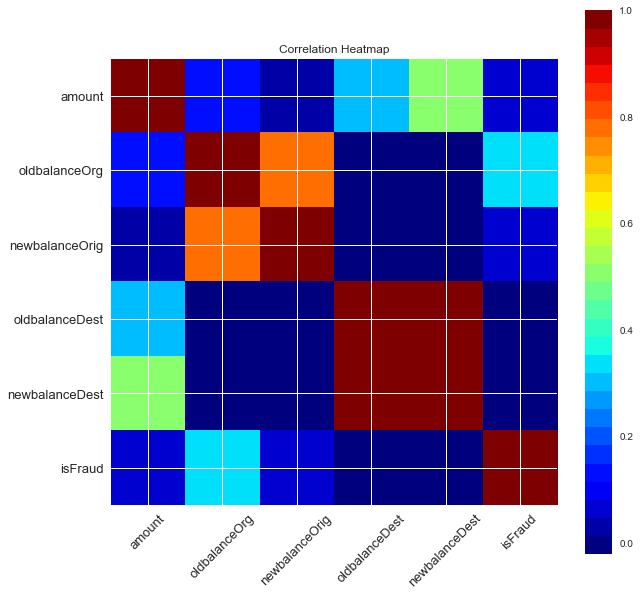

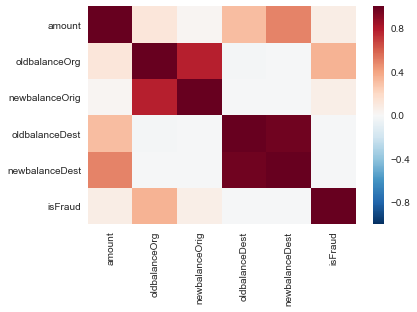

In [12]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
correlation_plot(tmp)

# Alternatively, we can use quick seaborn
# plot the heatmap
sns.heatmap(tmp.corr())

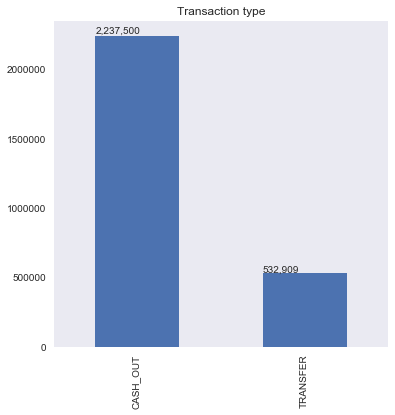

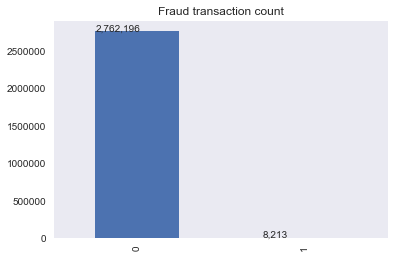

In [13]:
ax = tmp.type.value_counts().plot(kind='bar', title="Transaction type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

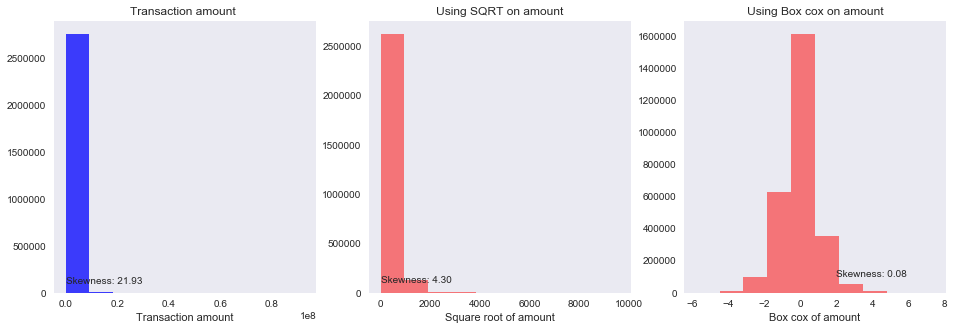

In [64]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

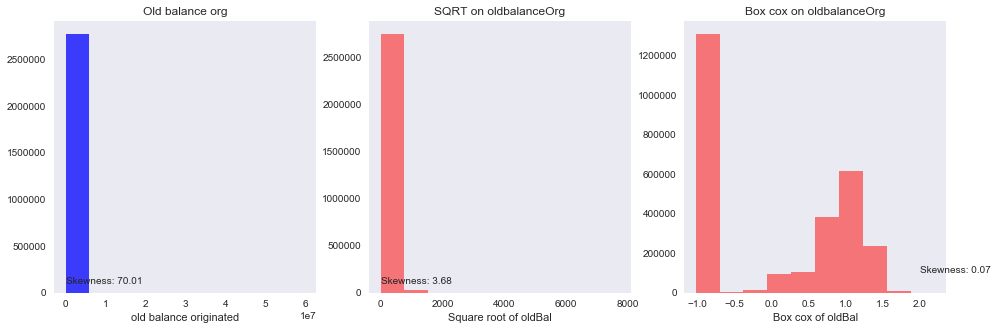

In [65]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceOrg'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("old balance originated") 
plt.title("Old balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceOrg']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceOrg']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()

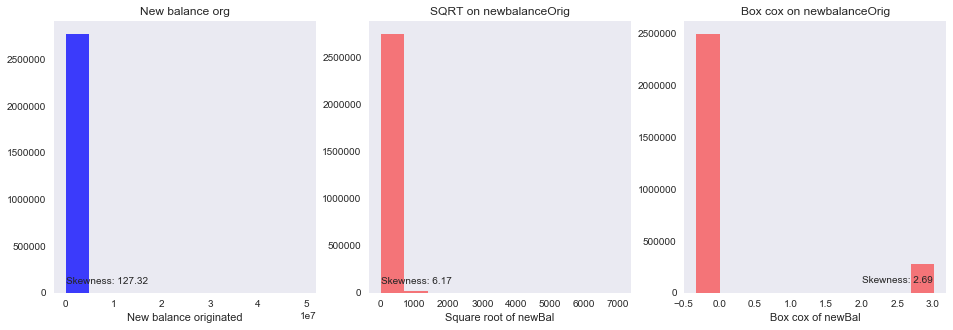

In [66]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()

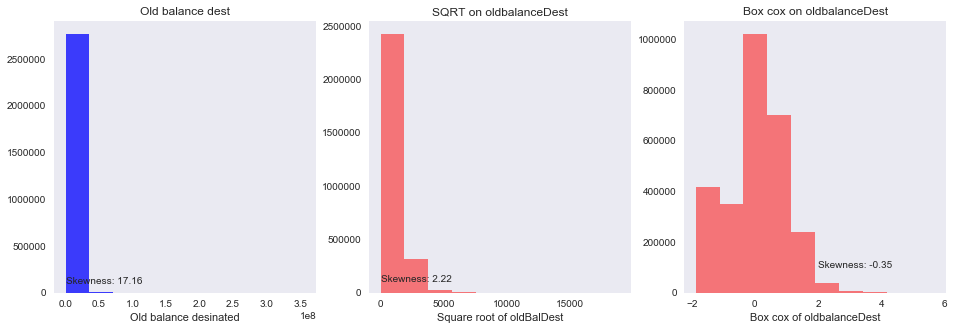

In [69]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()

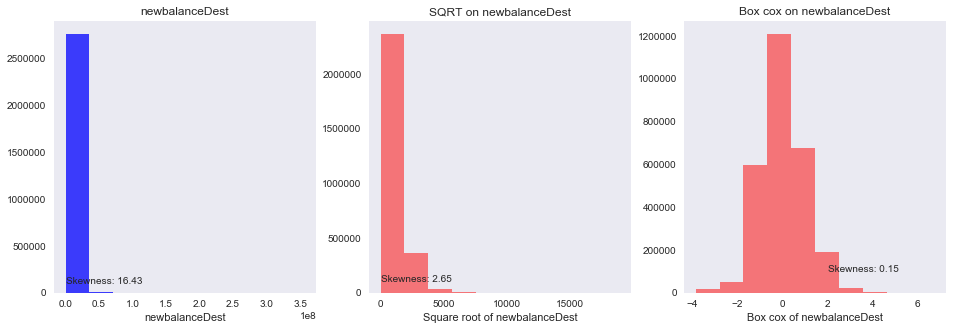

In [70]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()

In [47]:
from statsmodels.tools import categorical
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)
tmp.drop(['type'], axis=1, inplace=True)


In [48]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.2965%


As can be seen, I have already filtered unrelated transaction type out and keep only relevant. There're only actual fraud of 0.3%. This is very imbalance data.

In this notebook, I will quickly use traditional *under*-sampling method (there are several other ways; under and over sampling, SMOTE, etc).

I will under sample the dataset by creating a 50-50 ratio of randomly selecting 'x' amount of sample from majority class, with 'x' being the total number of records with the minority class.


In [73]:
tmp.columns.tolist()

['isFraud',
 'type_num',
 'amount_boxcox',
 'oldbalanceOrg_boxcox',
 'newbalanceOrg_boxcox',
 'oldbalanceDest_boxcox',
 'newbalanceDest_boxcox']

In [72]:
# Reset the index
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount'], axis=1, inplace=True)

X = tmp.ix[:, tmp.columns != 'isFraud']
y = tmp.ix[:, tmp.columns == 'isFraud']

In [74]:
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  16426


## Logistic regression classifier - Undersampled data
We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:

Accuracy = (TP+TN)/total

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.

Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite.



In [75]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions: ", format(len(X_train_undersample)+len(X_test_undersample),',d'))

Number transactions train dataset:  1,939,286
Number transactions test dataset:  831,123
Total number of transactions:  2,770,409

Number transactions train dataset:  11,498
Number transactions test dataset:  4,928
Total number of transactions:  16,426


In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def printing_Kfold_scores(x_train_data, y_train_data, kfoldnum, c_array):
    # define K-Fold
    fold = KFold(len(y_train_data), kfoldnum,shuffle=False) 

    results_table = pd.DataFrame(index = range(len(c_array),3), columns = ['C_parameter','Mean recall score', 'Mean precision score'])
    results_table['C_parameter'] = c_array

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_array:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        precision_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            
            precision_acc = precision_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            precision_accs.append(precision_acc)
            print("Iteration {}: recall score = {:.4f}, precision score = {:.4f}".format(iteration, recall_acc, precision_acc))

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        results_table.ix[j, 'Mean precision score'] = np.mean(precision_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('Mean precision score ', np.mean(precision_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [77]:
c_param_range = [0.01,0.1,1,10,100]
k_fold = 5
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample, k_fold, c_param_range)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration 1: recall score = 0.9571, precision score = 0.8413
Iteration 2: recall score = 0.9505, precision score = 0.8314
Iteration 3: recall score = 0.9626, precision score = 0.8424
Iteration 4: recall score = 0.9487, precision score = 0.8531
Iteration 5: recall score = 0.9573, precision score = 0.8455

Mean recall score  0.955226795118
Mean precision score  0.842764167476

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration 1: recall score = 0.9614, precision score = 0.9029
Iteration 2: recall score = 0.9653, precision score = 0.9070
Iteration 3: recall score = 0.9706, precision score = 0.9083
Iteration 4: recall score = 0.9604, precision score = 0.9284
Iteration 5: recall score = 0.9667, precision score = 0.9100

Mean recall score  0.964892921734
Mean precision score  0.911317890499

-----------------------------

In [78]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset: 0.9594


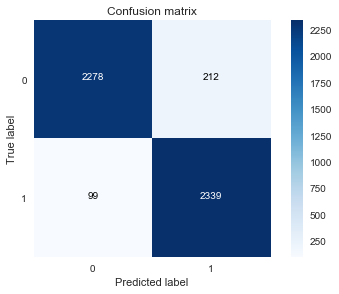

In [79]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

print("Recall metric in the testing dataset: {0:.4f}".format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [80]:
# The estimated coefficients will all be around 1:
print(lr)

print(lr.intercept_ )
print(lr.coef_)
print(X_test.head(1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[-11.73]
[[  0.09  -1.07  10.02  -1.95   0.3   -0.97]]
        type_num  amount_boxcox  oldbalanceOrg_boxcox  newbalanceOrg_boxcox  \
447038         0      -0.165122              -1.01972             -0.331128   

        oldbalanceDest_boxcox  newbalanceDest_boxcox  
447038               0.490115               0.308455  


Recall metric in the testing dataset:  0.963488843813


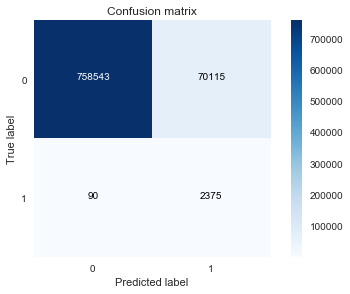

In [81]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

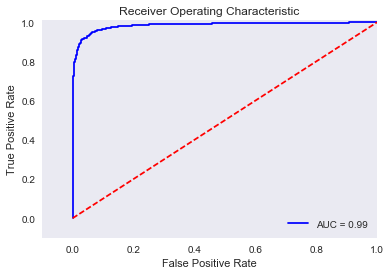

In [82]:
# ROC CURVE
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()